# A Deep Learning Demo for time series data

#### including Classification and Regression

### Overview

Deep learning is proven to be very effective for Time Series Classification (TSC) tasks after the extensive experiments done in [1], especially Convolution based architectures i.e. FCN and ResNet [2]. A while later, InceptionTime (Convolution based) was proposed to become the new state-of-the-art deep learning model for TSC [3]. In [4], new hand-crafted convolution filters were proposed to boost InceptionTime. The model proposed in [4], Hybrid InceptionTime (H-InceptionTime) is currently the state-of-the-art deep learning model for TSC.

More recently, in the latest Time Series Regression (TSR) review [5], the deep learning model InceptionTime is seen to be the state-of-the-art deep learning model.

In this demo, we cover the usage of the deep learning models for both TSC and TSR

### Contents

1. Imports
2. Classification
    - InceptionTime
    - H-InceptionTime
    - Saving model
3. Regression
    - InceptionTime
    - Saving and Loading model
4. Deep Learning for any time series task
5. References

### 1. Imports

Import the deep learning models for classification and regression, the data loader and InceptionNetwork.

In [6]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from sklearn.decomposition import PCA
from tensorflow.keras import backend as k

from aeon.classification.deep_learning.fcn import FCNClassifier
from aeon.classification.deep_learning.inception_time import InceptionTimeClassifier
from aeon.datasets import load_classification, load_regression
from aeon.networks.inception import InceptionNetwork
from aeon.regression.deep_learning.inception_time import InceptionTimeRegressor

### 2. Classification

#### InceptionTime

The InceptionTime model is an ensemble of multiple (by default five) Inception models. Each Inception model is a Convolutional Neural Network made of six Inception modules as seen in the Figure below. Each Inception module is composed of multiple (by default three) convolution layer in parallel and a max-pooling operation as well.
![InceptionTime](img/Inception.png)

In [17]:
xtrain, ytrain, meta = load_classification(name="ArrowHead", split="train")
xtest, ytest, meta = load_classification(name="ArrowHead", split="test")

inc = InceptionTimeClassifier(n_classifiers=5, use_custom_filters=False, n_epochs=3)
inc.fit(X=xtrain, y=ytrain)
ypred = inc.predict(X=xtest)

print("Predictions: ", ypred[0:5])
print("Ground Truth: ", ytest[0:5])

3/3 [==============================] - 1s 98ms/step
Predictions:  ['0' '0' '0' '0' '0']
Ground Truth:  ['0' '0' '0' '0' '0']


#### H-InceptionTime

Just as InceptionTime, H-InceptionTime is an ensemble of multiple H-Inception models. The model can be seen in the figure below, where the additional custom filters are added in parallel to the first Inception module.
![H-InceptionTime](img/H-Inception.png)

The usage of H-InceptionTime can be done by setting the ```use_custom_filters``` flag to True. This is the default setup, not setting this flag to True will results in using the H-InceptionTime by default and only by setting it to False that InceptionTime is used.

In [18]:
xtrain, ytrain, meta = load_classification(name="ArrowHead", split="train")
xtest, ytest, meta = load_classification(name="ArrowHead", split="test")

inc = InceptionTimeClassifier(n_classifiers=5, use_custom_filters=True, n_epochs=3)
inc.fit(X=xtrain, y=ytrain)
ypred = inc.predict(X=xtest)

print("Predictions: ", ypred[0:5])
print("Ground Truth: ", ytest[0:5])

3/3 [==============================] - 1s 67ms/step
Predictions:  ['0' '0' '0' '0' '0']
Ground Truth:  ['0' '0' '0' '0' '0']


#### Saving model

While training a deep learning model with `aeon`, a default callback is used to save the best model during training based on the training loss. This saved model is then loaded to use for evaluation and deleted once no longer used. This intermediate step is to avoid saving the model to file when the user is not in need of it later. This however can be changed by setting the `save_best_model` flag to True. The default name for the model is "best_model" with a `.hdf5` extension and will be saved in the default working directory. To change this, simply change the `file_path` and `best_file_name` parameters to your preference. 

The same settings can be used if the user needs to save the last model during training as well. This is done by simply setting the flag `save_last_model` to True. The name of this saved model can be set by changing the `last_file_name` parameter and the `file_path` as well.

Here is an example on saving the best and last models of an FCN model:

In [10]:
xtrain, ytrain, meta = load_classification(name="ArrowHead", split="train")
xtest, ytest, meta = load_classification(name="ArrowHead", split="test")

fcn = FCNClassifier(
    save_best_model=True,
    save_last_model=True,
    file_path="./",
    best_file_name="best_fcn",
    last_file_name="last_fcn",
    n_epochs=2,
)

# The following is commented to avoid CI doing the saving for no reason

# fcn.fit(X=xtrain, y=ytrain)
# ypred = fcn.predict(X=xtest)

### 3. Regression

#### InceptionTime

As for classification, the InceptionTime model for TSR tasks is an ensemble of five different Inception models. The difference here is just in the last layer where the number of output neurons is one and no activation is used. The loss function used in this case is the Mean Squared Error.

In [19]:
xtrain, ytrain, meta = load_regression(name="Covid3Month", split="train")
xtest, ytest, meta = load_regression(name="Covid3Month", split="test")

inc = InceptionTimeRegressor(n_regressors=5, n_epochs=1, use_custom_filters=False)
inc.fit(X=xtrain, y=ytrain)
ypred = inc.predict(X=xtest)

print("Predictions: ", ypred[0:5])
print("Ground Truth: ", ytest[0:5])

1/1 [==============================] - 0s 363ms/step
Predictions:  [-1.30767149e-01 -7.55380299e-03  2.08801683e-04 -1.47540897e-02
 -1.30448112e+00]
Ground Truth:  [0.0118838  0.00379507 0.08298755 0.04510921 0.12783075]


The model saving technique for regression models is the same as for classification ones.

### 4. Deep Learning for any time series task

Suppose you want to use a single Inception Network, for example to perform some self-supervised learning.  This is simple in aeon because of the structure on the network module. You can create any of model to perform any task using any of the Neural Networks in the module.

In this Example we will be re-creating the TRILITE Self-Supervised Learning model from [6]. This model uses a deep learning encoder coupled with a triplet loss mechanism to learn a compact latent representation of the time series data.

In [20]:
# define self-supervised space dimension

n_dim = 16

# load the data

xtrain, ytrain, meta = load_classification(name="ArrowHead", split="train")
xtest, ytest, meta = load_classification(name="ArrowHead", split="test")

# Flip axis to be handled correctly in tensorflow

xtrain = np.transpose(xtrain, axes=(0, 2, 1))
xtest = np.transpose(xtest, axes=(0, 2, 1))

Now define the triplet loss needed for the SSL model. Taken from [5].

In [21]:
def triplet_loss_function(alpha):
    def temp(ytrue, ypred):
        ref = ypred[:, :, 0]
        pos = ypred[:, :, 1]
        neg = ypred[:, :, 2]

        ref = k.cast(ref, dtype=ref.dtype)
        pos = k.cast(pos, dtype=ref.dtype)
        neg = k.cast(neg, dtype=ref.dtype)

        loss = k.maximum(
            k.sum(
                tf.math.subtract(
                    tf.math.add(k.square(ref - pos), alpha), k.square(ref - neg)
                ),
                axis=1,
            ),
            0,
        )

        return loss

    return temp

Now define the network with the output self-supervised projection layer.

In [22]:
# Define the triplets input layers

input_ref_layer = tf.keras.layers.Input(xtrain.shape[1:])
input_pos_layer = tf.keras.layers.Input(xtrain.shape[1:])
input_neg_layer = tf.keras.layers.Input(xtrain.shape[1:])

inc_network = InceptionNetwork()
input_layer, gap_layer = inc_network.build_network(input_shape=xtrain.shape[1:])

encoder = tf.keras.models.Model(inputs=input_layer, outputs=gap_layer)

output_layer_ref = tf.keras.layers.Reshape(target_shape=(-1, 1))(
    tf.keras.layers.Dense(units=n_dim)(encoder(input_ref_layer))
)
output_layer_pos = tf.keras.layers.Reshape(target_shape=(-1, 1))(
    tf.keras.layers.Dense(units=n_dim)(encoder(input_pos_layer))
)
output_layer_neg = tf.keras.layers.Reshape(target_shape=(-1, 1))(
    tf.keras.layers.Dense(units=n_dim)(encoder(input_neg_layer))
)

output_layer = tf.keras.layers.Concatenate(axis=-1)(
    [output_layer_ref, output_layer_pos, output_layer_neg]
)

SSL_model = tf.keras.models.Model(
    inputs=[input_ref_layer, input_pos_layer, input_neg_layer], outputs=output_layer
)

SSL_model.compile(loss=triplet_loss_function(alpha=1e-5))

Define your triplets beforehand

In [23]:
def triplet_generation(x):
    w1 = np.random.choice(np.linspace(start=0.6, stop=1, num=1000), size=1)
    w2 = (1 - w1) / 2

    ref = np.random.permutation(x[:])

    n = int(ref.shape[0])

    pos = np.zeros(shape=ref.shape)
    neg = np.zeros(shape=ref.shape)

    all_indices = np.arange(start=0, stop=n)

    for i in range(n):
        temp_indices = np.delete(arr=all_indices, obj=i)
        indice_neg = int(np.random.choice(temp_indices, size=1))

        temp_indices = np.delete(arr=all_indices, obj=[i, indice_neg])
        indice_b = int(np.random.choice(temp_indices, size=1))

        indice_c = int(np.random.choice(temp_indices, size=1))

        indice_b2 = int(np.random.choice(temp_indices, size=1))

        indice_c2 = int(np.random.choice(temp_indices, size=1))

        a = ref[i].copy()

        nota = ref[indice_neg].copy()

        b = ref[indice_b].copy()
        c = ref[indice_c].copy()

        b2 = ref[indice_b2].copy()
        c2 = ref[indice_c2].copy()

        # MixingUp

        pos[i] = w1 * a + w2 * b + w2 * c
        neg[i] = w1 * nota + w2 * b2 + w2 * c2

    return ref, pos, neg

Generate the triplets

In [29]:
xtrain_ref, xtrain_pos, xtrain_neg = triplet_generation(x=xtrain)

Set the model's callbacks

In [25]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=50, min_lr=0.0001
)

file_path = "./best_ssl_model.hdf5"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=file_path, monitor="loss", save_best_only=True
)

callbacks = [reduce_lr, model_checkpoint]

Train your model

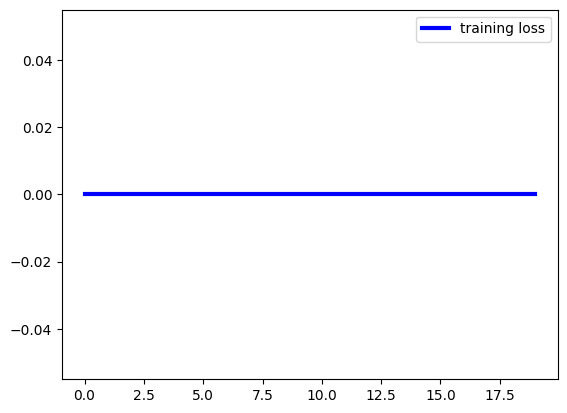

In [30]:
history = SSL_model.fit(
    [xtrain_ref, xtrain_pos, xtrain_neg],
    np.zeros(shape=len(xtrain)),
    epochs=20,
    callbacks=callbacks,
    verbose=False,
)

plt.figure()
plt.plot(history.history["loss"], lw=3, color="blue", label="training loss")
plt.legend()
plt.show()

Plot the 2D representation of the train data now

2/2 [==============================] - 1s 16ms/step


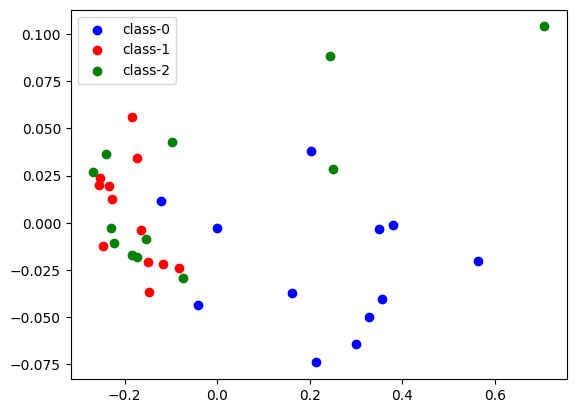

In [31]:
plt.cla()
plt.clf()
plt.close()
plt.figure()

pca = PCA(n_components=2)

# load best model
model = tf.keras.models.load_model("./best_ssl_model.hdf5", compile=False)
latent_space = model.predict([xtrain, xtrain, xtrain])
latent_space = latent_space[:, :, 0]

pca.fit(latent_space)
latent_space_2d = pca.transform(latent_space)

colors = ["blue", "red", "green"]

for c in range(len(np.unique(ytrain))):
    plt.scatter(
        latent_space_2d[ytrain.astype(np.int64) == c][:, 0],
        latent_space_2d[ytrain.astype(np.int64) == c][:, 1],
        color=colors[c],
        label="class-" + str(c),
    )


plt.legend()
plt.show()

In [32]:
os.remove("./best_ssl_model.hdf5")

### 5. References

- [1] Ismail Fawaz, Hassan, et al. "Deep learning for time series classification: a
    review." Data mining and knowledge discovery 33.4 (2019): 917-963.
- [2] Wang, Zhiguang et al. "Time series classification from scratch with deep neural
    networks: A strong baseline." 2017 International joint conference on neural networks (IJCNN). IEEE, 2017.
- [3] Ismail Fawaz, Hassan, et al. "Inceptiontime: Finding alexnet for time series
    classification." Data Mining and Knowledge Discovery 34.6 (2020): 1936-1962.
- [4] Ismail-Fawaz, Ali, et al. "Deep Learning For Time Series Classification Using New
    Hand-Crafted Convolution Filters." International Conference on Big Data. IEEE, (2022).
- [5] Guijo-Rubio, David, et al. "Unsupervised Feature Based Algorithms for Time Series
    Extrinsic Regression." arXiv preprint arXiv:2305.01429 (2023).
- [6] Ismail-Fawaz, Ali, et al. "Enhancing Time Series Classification with Self-Supervised Learning."
    International Conference on Agents and Artificial Intelligence ICAART (2023).